In [1]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.0 ; cuda:  cpu
detectron2: 0.6


In [68]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random, pickle
import glob

from matplotlib import pyplot as plt

#
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog


from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer



I will use Faster RCNN model from model zoo

In [5]:
config_file_path = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [6]:
output_dir = "output/object_detection"
num_class = 2
device = "cpu"

In [7]:
train_dataset_name = "Toy_train"
train_images_path = "data/train"
train_json_annot_path = "data/train_toy_annotations_COCO.json"

In [8]:
test_dataset_name = "Toy_test"
test_images_path = "data/test"
test_json_annot_path = "data/test_toy_annotations_COCO.json"

In [57]:
cfg_save_path = "output/OD_cfg.pickle"

Register my datasets with the annotations

In [9]:
register_coco_instances(name=train_dataset_name, metadata={},
                        json_file=train_json_annot_path,
                        image_root=train_images_path)

register_coco_instances(name=test_dataset_name, metadata={},
                        json_file=test_json_annot_path,
                        image_root=test_images_path)

In [40]:
def plot_samples(dataset_name, n=1):
    '''
    show random examples from the dataset with annotations
    '''
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)

    for s in random.sample(dataset_custom, n):
        img = cv2.imread(s["file_name"])
        v = Visualizer(img[:,:,::-1], metadata=dataset_custom_metadata, scale=0.5)
        v = v.draw_dataset_dict(s)
        plt.figure(figsize=(10, 8))
        plt.imshow(v.get_image())
        plt.axis("off")
        plt.show()

[06/07 17:10:39 d2.data.datasets.coco]: Loaded 41 images in COCO format from data/train_toy_annotations_COCO.json


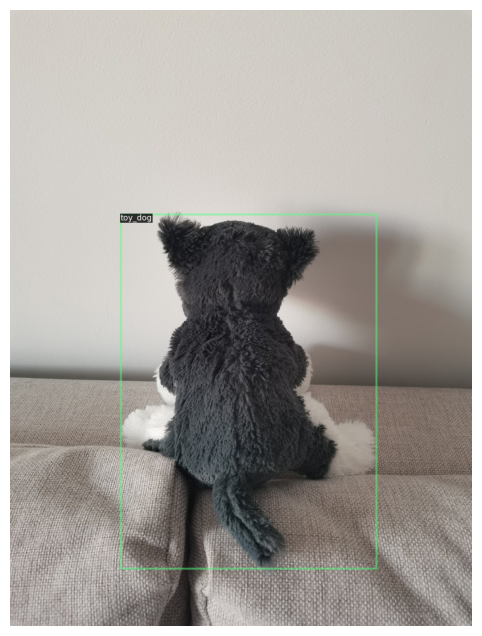

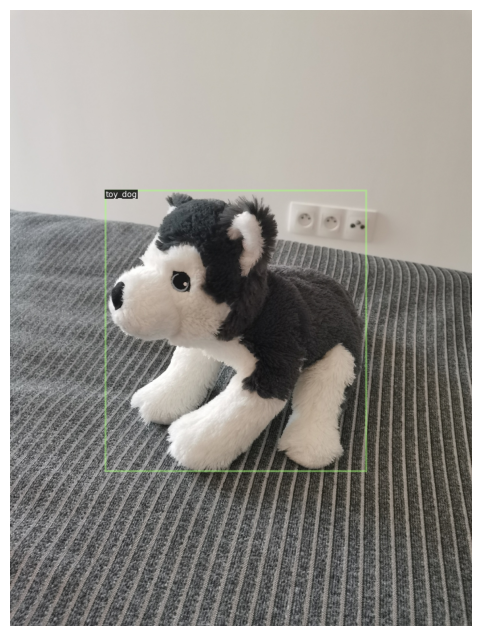

In [41]:
plot_samples(dataset_name=train_dataset_name, n=2)

In [51]:
def get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, test_dataset_name, num_classes, device, output_dir):
    '''
    prepare configuration file for fine-tuning model
    '''
    cfg = get_cfg()

    cfg.merge_from_file(model_zoo.get_config_file(config_file_path))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
    cfg.DATASETS.TRAIN = (train_dataset_name, )
    cfg.DATASETS.TEST = (test_dataset_name, )

    cfg.DATALOADER.NUM_WORKERS = 2

    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 1000
    cfg.SOLVER.STEPS = []

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.DEVICE = device
    cfg.OUTPUT_DIR = output_dir

    return cfg

In [52]:
cfg = get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, test_dataset_name, num_class, device, output_dir)

In [55]:
cfg.MODEL.DEVICE

'cpu'

In [58]:
#save config file
with open(cfg_save_path, 'wb') as f:
    pickle.dump(cfg, f, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
#create directoru for the output of the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [62]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/07 17:29:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:05, 32.0MB/s]                            
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pr

[06/07 17:30:00 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\Helen\AppData\Local\Programs\Python\Python39\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/07 17:33:26 d2.utils.events]:  eta: 2:49:50  iter: 19  total_loss: 1.351  loss_cls: 1.149  loss_box_reg: 0.184  loss_rpn_cls: 0.002105  loss_rpn_loc: 0.002239    time: 10.2314  last_time: 11.5622  data_time: 0.1200  last_data_time: 0.0017   lr: 4.9953e-06  
[06/07 17:37:25 d2.utils.events]:  eta: 2:58:03  iter: 39  total_loss: 1.192  loss_cls: 1.023  loss_box_reg: 0.1774  loss_rpn_cls: 0.001974  loss_rpn_loc: 0.002081    time: 11.0292  last_time: 9.4056  data_time: 0.0020  last_data_time: 0.0025   lr: 9.9902e-06  
[06/07 17:41:01 d2.utils.events]:  eta: 2:52:22  iter: 59  total_loss: 0.9549  loss_cls: 0.7414  loss_box_reg: 0.1865  loss_rpn_cls: 0.0009038  loss_rpn_loc: 0.003024    time: 10.9544  last_time: 9.2092  data_time: 0.0019  last_data_time: 0.0014   lr: 1.4985e-05  
[06/07 17:44:41 d2.utils.events]:  eta: 2:48:42  iter: 79  total_loss: 0.7242  loss_cls: 0.5348  loss_box_reg: 0.1937  loss_rpn_cls: 0.001422  loss_rpn_loc: 0.00247    time: 10.9618  last_time: 10.9369  data_tim

In [64]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

### Test the model

In [65]:
#load config file
with open(cfg_save_path, 'rb') as f:
    cfg = pickle.load(f)

#load trained model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/07 21:28:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/object_detection\model_final.pth ...


In [66]:
def on_image(image_path, predictor):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], metadata={}, scale=0.5, instance_mode=ColorMode.SEGMENTATION)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize = (9,6))
    plt.imshow(v.get_image())
    plt.axis("off")
    plt.show()

Test on images from test set

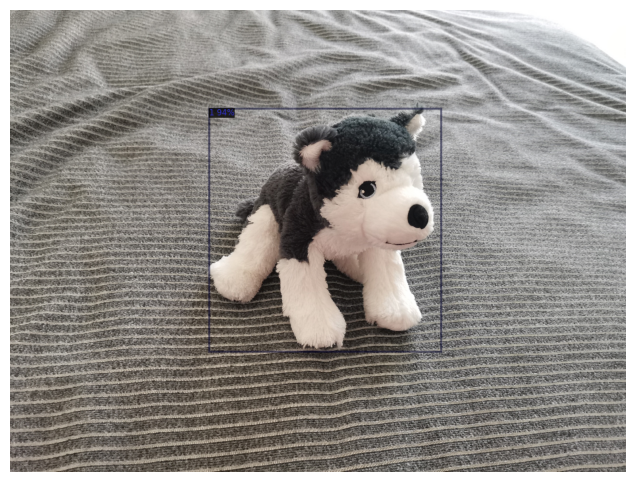

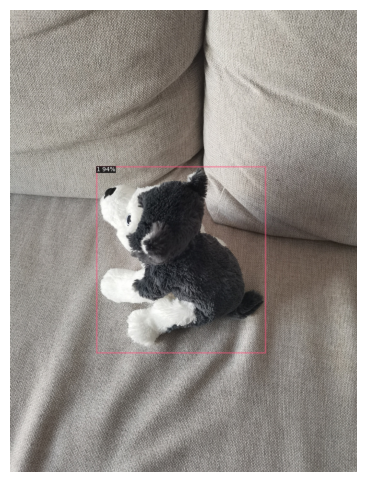

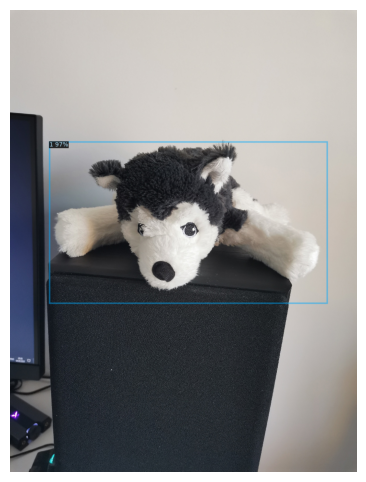

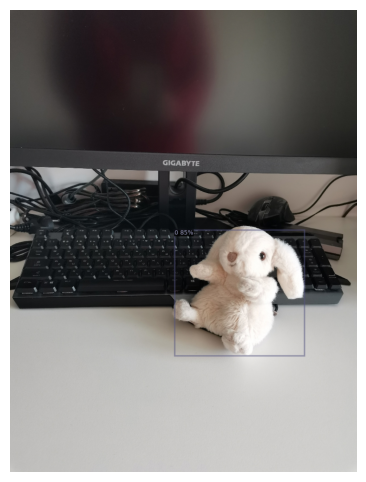

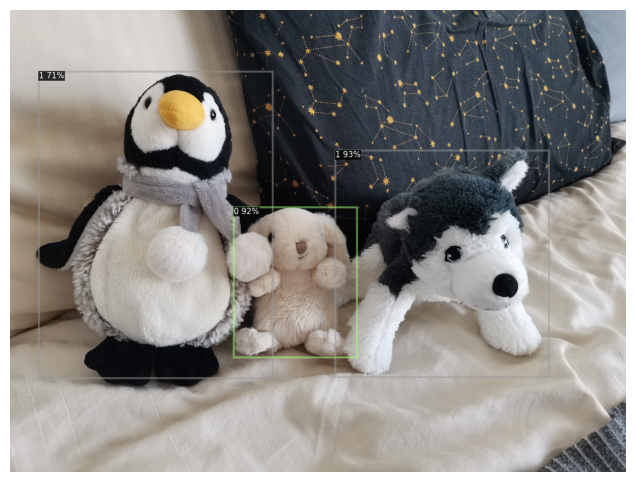

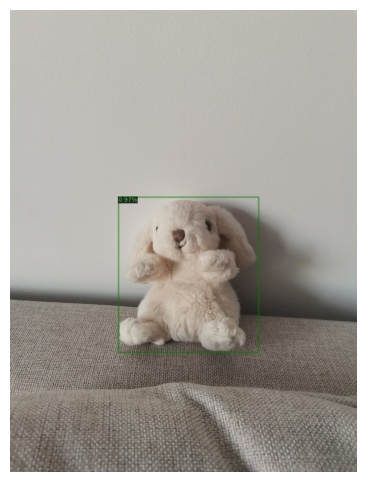

In [69]:
image_path = "data/test"
for filename in glob.glob(image_path + "/*.jpg"):
    on_image(filename, predictor)

### Evaluate the performance of the model

In [70]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("Toy_test", output_dir="evaluation")
val_loader = build_detection_test_loader(cfg, "Toy_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[06/07 21:30:12 d2.data.datasets.coco]: Loaded 6 images in COCO format from data/test_toy_annotations_COCO.json
[06/07 21:30:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/07 21:30:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/07 21:30:12 d2.data.common]: Serializing 6 elements to byte tensors and concatenating them all ...
[06/07 21:30:12 d2.data.common]: Serialized dataset takes 0.00 MiB
[06/07 21:30:12 d2.evaluation.evaluator]: Start inference on 6 batches
[06/07 21:30:28 d2.evaluation.evaluator]: Total inference time: 0:00:02.705359 (2.705359 s / iter per device, on 1 devices)
[06/07 21:30:28 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (2.302175 s / iter per device, on 1 devices)
[06/07 21:30:28 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/07 21: